# Cloud detection model

In [18]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [19]:
from pathlib import Path
from torch.utils.data import Dataset, DataLoader, sampler
from PIL import Image
import torch
import matplotlib.pyplot as plt
import time
import tqdm

In [20]:
class CloudDataset(Dataset):
    def __init__(self, r_dir, g_dir, b_dir, gt_dir, pytorch=True):
        super().__init__()
        
        # Loop through the files in red folder and combine, into a dictionary, the other bands
        self.files = [self.combine_files(f, g_dir, b_dir, gt_dir) for f in r_dir.iterdir() if not f.is_dir()]
        self.pytorch = pytorch
        
    def combine_files(self, r_file: Path, g_dir, b_dir, gt_dir):

        files = {'red': r_file,
                 'green': g_dir/r_file.name.replace('red', 'green'),
                 'blue': b_dir/r_file.name.replace('red', 'blue'),
                 'gt': gt_dir/r_file.name.replace('red', 'gt')}

        return files
                                       
    def __len__(self):
        
        return len(self.files)
     
    def open_as_array(self, idx, invert=False, include_nir=False):

        raw_rgb = np.stack([np.array(Image.open(self.files[idx]['red'])),
                            np.array(Image.open(self.files[idx]['green'])),
                            np.array(Image.open(self.files[idx]['blue'])),
                           ], axis=2)
        include_nir = False
        if include_nir:
            nir = np.expand_dims(np.array(Image.open(self.files[idx]['nir'])), 2)
            raw_rgb = np.concatenate([raw_rgb, nir], axis=2)
    
        if invert:
            raw_rgb = raw_rgb.transpose((2,0,1))
    
        # normalize
        return (raw_rgb / np.iinfo(raw_rgb.dtype).max)
    

    def open_mask(self, idx, add_dims=False):
        
        raw_mask = np.array(Image.open(self.files[idx]['gt']))
        raw_mask = np.where(raw_mask==255, 1, 0)
        
        return np.expand_dims(raw_mask, 0) if add_dims else raw_mask
    
    def __getitem__(self, idx):
        
        x = torch.tensor(self.open_as_array(idx, invert=self.pytorch, include_nir=True), dtype=torch.float32)
        y = torch.tensor(self.open_mask(idx, add_dims=False), dtype=torch.torch.int64)
        
        return x, y
    
    def open_as_pil(self, idx):
        
        arr = 256*self.open_as_array(idx)
        
        return Image.fromarray(arr.astype(np.uint8), 'RGB')
    
    def __repr__(self):
        s = 'Dataset class with {} files'.format(self.__len__())

        return s

In [21]:
base_path = Path('/home/diego/Desktop/spacechallenges2025/CloudDetection/archive/38-Cloud_training')
data = CloudDataset(base_path/'train_red', 
                    base_path/'train_green', 
                    base_path/'train_blue',
                    base_path/'train_gt')
len(data)

8400

In [22]:
x, y = data[1000]
x.shape, y.shape

(torch.Size([3, 384, 384]), torch.Size([384, 384]))

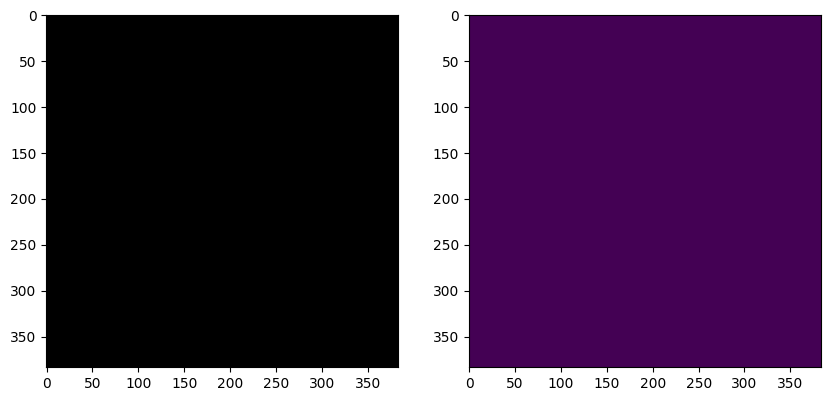

In [23]:
fig, ax = plt.subplots(1,2, figsize=(10,9))
ax[0].imshow(data.open_as_array(150))
ax[1].imshow(data.open_mask(150))

In [24]:
train_ds, valid_ds = torch.utils.data.random_split(data, (6000, 2400))

In [25]:
train_dl = DataLoader(train_ds, batch_size=12, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=12, shuffle=True)

In [26]:
xb, yb = next(iter(train_dl))
xb.shape, yb.shape

(torch.Size([12, 3, 384, 384]), torch.Size([12, 384, 384]))

In [27]:
from torch import nn
class UNET(nn.Module):
    def __init__(self, in_channels=3, out_channels=2):
        super().__init__()

        self.conv1 = self.contract_block(in_channels, 32, 7, 3)
        self.conv2 = self.contract_block(32, 64, 3, 1)
        self.conv3 = self.contract_block(64, 128, 3, 1)

        self.upconv3 = self.expand_block(128, 64, 3, 1)
        self.upconv2 = self.expand_block(64*2, 32, 3, 1)
        self.upconv1 = self.expand_block(32*2, out_channels, 3, 1)

    def __call__(self, x):

        # downsampling part
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)

        upconv3 = self.upconv3(conv3)

        upconv2 = self.upconv2(torch.cat([upconv3, conv2], 1))
        upconv1 = self.upconv1(torch.cat([upconv2, conv1], 1))

        return upconv1

    def contract_block(self, in_channels, out_channels, kernel_size, padding):

        contract = nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
                                 )

        return contract

    def expand_block(self, in_channels, out_channels, kernel_size, padding):

        expand = nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1) 
                            )
        return expand

In [28]:
unet = UNET(3,2)

In [29]:
# testing one pass
xb, yb = next(iter(train_dl))
xb.shape, yb.shape

(torch.Size([12, 3, 384, 384]), torch.Size([12, 384, 384]))

In [30]:
pred = unet(xb)
pred.shape

torch.Size([12, 2, 384, 384])

In [31]:
import time
from IPython.display import clear_output

def train(model, train_dl, valid_dl, loss_fn, optimizer, acc_fn, epochs=1):
    start = time.time()
    model.cpu()

    train_loss, valid_loss = [], []

    best_acc = 0.0

    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch, epochs - 1))
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train(True)  # Set trainind mode = true
                dataloader = train_dl
            else:
                model.train(False)  # Set model to evaluate mode
                dataloader = valid_dl

            running_loss = 0.0
            running_acc = 0.0

            step = 0

            # iterate over data
            for x, y in tqdm.tqdm(dataloader):
                x = x.cpu()
                y = y.cpu()
                step += 1

                # forward pass
                if phase == 'train':
                    # zero the gradients
                    optimizer.zero_grad()
                    outputs = model(x)
                    loss = loss_fn(outputs, y)

                    # the backward pass frees the graph memory, so there is no 
                    # need for torch.no_grad in this training pass
                    loss.backward()
                    optimizer.step()
                    # scheduler.step()

                else:
                    with torch.no_grad():
                        outputs = model(x)
                        loss = loss_fn(outputs, y.long())

                # stats - whatever is the phase
                acc = acc_fn(outputs, y)

                running_acc  += acc.detach()*dataloader.batch_size
                running_loss += loss.detach()*dataloader.batch_size

                #print('Current step: {}  Loss: {}  Acc: {}'.format(step, loss, acc))

                if step % 100 == 0:
                    # clear_output(wait=True)
                    print('Current step: {}  Loss: {}  Acc: {}'.format(step, loss, acc))
                    # print(torch.cuda.memory_summary())

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_acc / len(dataloader.dataset)

            #clear_output(wait=True)
            print('Epoch {}/{}'.format(epoch, epochs - 1))
            print('-' * 10)
            print('{} Loss: {:.4f} Acc: {}'.format(phase, epoch_loss, epoch_acc))
            print('-' * 10)

            train_loss.append(epoch_loss) if phase=='train' else valid_loss.append(epoch_loss)

            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), 'best_cloud_model_complete_v2.pth')
                print(f'New best model saved! Accuracy: {best_acc:.4f}')


    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))    
    
    return train_loss, valid_loss    

def acc_metric(predb, yb):
    return (predb.argmax(dim=1) == yb.cpu()).float().mean()

In [ ]:
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(unet.parameters(), lr=0.01)
train_loss, valid_loss = train(unet, train_dl, valid_dl, loss_fn, opt, acc_metric, epochs=50)

Epoch 0/49
----------


 20%|██        | 100/500 [08:04<33:41,  5.05s/it]

Current step: 100  Loss: 0.45899754762649536  Acc: 0.6874796748161316


 40%|████      | 200/500 [16:23<24:39,  4.93s/it]

Current step: 200  Loss: 0.25882193446159363  Acc: 0.8697329163551331


 60%|██████    | 300/500 [24:38<16:43,  5.02s/it]

Current step: 300  Loss: 0.44557031989097595  Acc: 0.7879073619842529


 80%|████████  | 400/500 [32:55<08:17,  4.98s/it]

Current step: 400  Loss: 0.4990488290786743  Acc: 0.7663314342498779


100%|██████████| 500/500 [41:15<00:00,  4.95s/it]


Current step: 500  Loss: 0.3089742362499237  Acc: 0.8652569651603699
Epoch 0/49
----------
train Loss: 0.3897 Acc: 0.7840366959571838
----------


 50%|█████     | 100/200 [03:00<02:59,  1.79s/it]

Current step: 100  Loss: 0.46388423442840576  Acc: 0.6634114384651184


100%|██████████| 200/200 [05:59<00:00,  1.80s/it]


Current step: 200  Loss: 0.4003797471523285  Acc: 0.7357194423675537
Epoch 0/49
----------
valid Loss: 0.3982 Acc: 0.7559518218040466
----------
New best model saved! Accuracy: 0.7560
Epoch 1/49
----------


 20%|██        | 100/500 [08:23<33:25,  5.01s/it]

Current step: 100  Loss: 0.2844075560569763  Acc: 0.8910590410232544


 40%|████      | 200/500 [16:47<25:11,  5.04s/it]

Current step: 200  Loss: 0.2979629635810852  Acc: 0.8085479736328125


 60%|██████    | 300/500 [25:11<16:38,  4.99s/it]

Current step: 300  Loss: 0.265140175819397  Acc: 0.8928104043006897


 80%|████████  | 400/500 [33:32<08:19,  4.99s/it]

Current step: 400  Loss: 0.23201535642147064  Acc: 0.9424850940704346


100%|██████████| 500/500 [41:54<00:00,  5.03s/it]


Current step: 500  Loss: 0.2545761466026306  Acc: 0.9160681962966919
Epoch 1/49
----------
train Loss: 0.3497 Acc: 0.8235945701599121
----------


 50%|█████     | 100/200 [03:22<03:22,  2.03s/it]

Current step: 100  Loss: 0.3564123809337616  Acc: 0.8437166810035706


100%|██████████| 200/200 [06:44<00:00,  2.02s/it]


Current step: 200  Loss: 0.2625267505645752  Acc: 0.8638091087341309
Epoch 1/49
----------
valid Loss: 0.2941 Acc: 0.8727750778198242
----------
New best model saved! Accuracy: 0.8728
Epoch 2/49
----------


 20%|██        | 100/500 [08:20<33:09,  4.97s/it]

Current step: 100  Loss: 0.18672829866409302  Acc: 0.9493651390075684


 40%|████      | 200/500 [16:36<24:43,  4.95s/it]

Current step: 200  Loss: 0.3449561595916748  Acc: 0.8403716087341309


 60%|██████    | 300/500 [24:54<16:45,  5.03s/it]

Current step: 300  Loss: 0.28952842950820923  Acc: 0.8702647089958191


 80%|████████  | 400/500 [33:11<08:16,  4.96s/it]

Current step: 400  Loss: 0.35360223054885864  Acc: 0.7906844615936279


100%|██████████| 500/500 [41:26<00:00,  4.97s/it]


Current step: 500  Loss: 0.16822576522827148  Acc: 0.9697384238243103
Epoch 2/49
----------
train Loss: 0.3298 Acc: 0.8423555493354797
----------


 50%|█████     | 100/200 [03:04<03:05,  1.86s/it]

Current step: 100  Loss: 0.2115294486284256  Acc: 0.9468654990196228


100%|██████████| 200/200 [06:08<00:00,  1.84s/it]


Current step: 200  Loss: 0.23302708566188812  Acc: 0.9331806302070618
Epoch 2/49
----------
valid Loss: 0.3027 Acc: 0.8723268508911133
----------
Epoch 3/49
----------


 20%|██        | 100/500 [08:12<33:03,  4.96s/it]

Current step: 100  Loss: 0.3450363576412201  Acc: 0.7794166803359985


 40%|████      | 200/500 [16:27<24:50,  4.97s/it]

Current step: 200  Loss: 0.35218346118927  Acc: 0.7870799899101257


 60%|██████    | 300/500 [24:45<16:33,  4.97s/it]

Current step: 300  Loss: 0.27531054615974426  Acc: 0.8553726673126221


 80%|████████  | 400/500 [33:00<08:18,  4.98s/it]

Current step: 400  Loss: 0.2640726864337921  Acc: 0.887865424156189


100%|██████████| 500/500 [41:17<00:00,  4.95s/it]


Current step: 500  Loss: 0.5268757939338684  Acc: 0.6577481627464294
Epoch 3/49
----------
train Loss: 0.3382 Acc: 0.8317224383354187
----------


 50%|█████     | 100/200 [03:00<02:59,  1.79s/it]

Current step: 100  Loss: 0.2939167022705078  Acc: 0.900800347328186


100%|██████████| 200/200 [06:01<00:00,  1.81s/it]


Current step: 200  Loss: 0.26062890887260437  Acc: 0.8870951533317566
Epoch 3/49
----------
valid Loss: 0.3075 Acc: 0.8640710711479187
----------
Epoch 4/49
----------


 20%|██        | 100/500 [08:14<33:01,  4.95s/it]

Current step: 100  Loss: 0.21601435542106628  Acc: 0.9051677584648132


 40%|████      | 200/500 [16:25<24:39,  4.93s/it]

Current step: 200  Loss: 0.4997345209121704  Acc: 0.7351780533790588


 60%|██████    | 300/500 [24:40<16:27,  4.94s/it]

Current step: 300  Loss: 0.32192492485046387  Acc: 0.8701674938201904


 80%|████████  | 400/500 [32:56<08:17,  4.97s/it]

Current step: 400  Loss: 0.42390334606170654  Acc: 0.7851743102073669


100%|██████████| 500/500 [41:13<00:00,  4.95s/it]


Current step: 500  Loss: 0.5162087082862854  Acc: 0.7111629843711853
Epoch 4/49
----------
train Loss: 0.3293 Acc: 0.8386732339859009
----------


 50%|█████     | 100/200 [03:10<03:11,  1.91s/it]

Current step: 100  Loss: 0.4637017548084259  Acc: 0.7353668212890625


100%|██████████| 200/200 [06:22<00:00,  1.91s/it]


Current step: 200  Loss: 0.2028871774673462  Acc: 0.968841016292572
Epoch 4/49
----------
valid Loss: 0.2888 Acc: 0.8723633885383606
----------
Epoch 5/49
----------


 20%|██        | 100/500 [08:15<32:44,  4.91s/it]

Current step: 100  Loss: 0.17844942212104797  Acc: 0.9550826549530029


 40%|████      | 200/500 [16:29<24:37,  4.93s/it]

Current step: 200  Loss: 0.4721193313598633  Acc: 0.7742184996604919


 60%|██████    | 300/500 [24:43<16:24,  4.92s/it]

Current step: 300  Loss: 0.17708157002925873  Acc: 0.9104896783828735


 80%|████████  | 400/500 [32:56<08:11,  4.91s/it]

Current step: 400  Loss: 0.23841552436351776  Acc: 0.9301288723945618


100%|██████████| 500/500 [41:08<00:00,  4.94s/it]


Current step: 500  Loss: 0.451958030462265  Acc: 0.7205963134765625
Epoch 5/49
----------
train Loss: 0.3208 Acc: 0.8491753935813904
----------


 50%|█████     | 100/200 [03:13<03:13,  1.93s/it]

Current step: 100  Loss: 0.23184512555599213  Acc: 0.9213957786560059


100%|██████████| 200/200 [06:27<00:00,  1.94s/it]


Current step: 200  Loss: 0.23691332340240479  Acc: 0.8593201637268066
Epoch 5/49
----------
valid Loss: 0.2953 Acc: 0.863578200340271
----------
Epoch 6/49
----------


 20%|██        | 100/500 [08:13<32:55,  4.94s/it]

Current step: 100  Loss: 0.22502757608890533  Acc: 0.8742890357971191


 40%|████      | 200/500 [16:26<24:25,  4.89s/it]

Current step: 200  Loss: 0.18981468677520752  Acc: 0.9061731696128845


 60%|██████    | 300/500 [24:38<16:25,  4.93s/it]

Current step: 300  Loss: 0.4873456656932831  Acc: 0.771729052066803


 80%|████████  | 400/500 [32:51<08:14,  4.95s/it]

Current step: 400  Loss: 0.619875431060791  Acc: 0.6566636562347412


100%|██████████| 500/500 [41:01<00:00,  4.92s/it]


Current step: 500  Loss: 0.2264811247587204  Acc: 0.9177415370941162
Epoch 6/49
----------
train Loss: 0.3091 Acc: 0.8557316660881042
----------


 50%|█████     | 100/200 [02:56<02:55,  1.76s/it]

Current step: 100  Loss: 0.24617497622966766  Acc: 0.8748829960823059


100%|██████████| 200/200 [05:53<00:00,  1.77s/it]


Current step: 200  Loss: 0.3547116816043854  Acc: 0.8643442988395691
Epoch 6/49
----------
valid Loss: 0.2902 Acc: 0.8757755756378174
----------
New best model saved! Accuracy: 0.8758
Epoch 7/49
----------


 20%|██        | 100/500 [08:09<32:40,  4.90s/it]

Current step: 100  Loss: 0.43994811177253723  Acc: 0.7397223711013794


 40%|████      | 200/500 [16:17<24:36,  4.92s/it]

Current step: 200  Loss: 0.35315290093421936  Acc: 0.8591251969337463


 60%|██████    | 300/500 [24:30<16:12,  4.86s/it]

Current step: 300  Loss: 0.17976807057857513  Acc: 0.9431548118591309


 80%|████████  | 400/500 [32:42<08:10,  4.90s/it]

Current step: 400  Loss: 0.37333932518959045  Acc: 0.774243950843811


100%|██████████| 500/500 [40:52<00:00,  4.90s/it]


Current step: 500  Loss: 0.44450780749320984  Acc: 0.7666456699371338
Epoch 7/49
----------
train Loss: 0.3101 Acc: 0.8530362248420715
----------


 50%|█████     | 100/200 [03:02<03:03,  1.84s/it]

Current step: 100  Loss: 0.1708623617887497  Acc: 0.9821494817733765


100%|██████████| 200/200 [06:04<00:00,  1.82s/it]


Current step: 200  Loss: 0.42145785689353943  Acc: 0.7705925703048706
Epoch 7/49
----------
valid Loss: 0.2860 Acc: 0.8706405758857727
----------
Epoch 8/49
----------


 20%|██        | 100/500 [08:10<32:38,  4.90s/it]

Current step: 100  Loss: 0.22540633380413055  Acc: 0.9291850924491882


 40%|████      | 200/500 [16:22<24:45,  4.95s/it]

Current step: 200  Loss: 0.255318284034729  Acc: 0.9017876386642456


 60%|██████    | 300/500 [24:35<16:22,  4.91s/it]

Current step: 300  Loss: 0.13484308123588562  Acc: 0.9831514954566956


 80%|████████  | 400/500 [32:47<08:13,  4.94s/it]

Current step: 400  Loss: 0.18240493535995483  Acc: 0.9716660976409912


100%|██████████| 500/500 [41:02<00:00,  4.92s/it]


Current step: 500  Loss: 0.3329637348651886  Acc: 0.8237168788909912
Epoch 8/49
----------
train Loss: 0.3062 Acc: 0.860872209072113
----------


 50%|█████     | 100/200 [02:47<02:43,  1.64s/it]

Current step: 100  Loss: 0.18376390635967255  Acc: 0.9463393688201904


100%|██████████| 200/200 [05:30<00:00,  1.65s/it]


Current step: 200  Loss: 0.17243044078350067  Acc: 0.9382668733596802
Epoch 8/49
----------
valid Loss: 0.2805 Acc: 0.869698166847229
----------
Epoch 9/49
----------


 20%|██        | 100/500 [07:54<30:44,  4.61s/it]

Current step: 100  Loss: 0.174735888838768  Acc: 0.9446315169334412


 40%|████      | 200/500 [16:22<32:01,  6.40s/it]

Current step: 200  Loss: 0.5405014157295227  Acc: 0.7657849192619324


 60%|██████    | 300/500 [25:26<16:48,  5.04s/it]

Current step: 300  Loss: 0.2681138515472412  Acc: 0.9186638593673706


 80%|████████  | 400/500 [34:00<07:47,  4.67s/it]

Current step: 400  Loss: 0.34396079182624817  Acc: 0.7916689515113831


100%|██████████| 500/500 [42:11<00:00,  5.06s/it]


Current step: 500  Loss: 0.21880684792995453  Acc: 0.9549741148948669
Epoch 9/49
----------
train Loss: 0.2980 Acc: 0.8639537692070007
----------


 50%|█████     | 100/200 [02:57<02:58,  1.78s/it]

Current step: 100  Loss: 0.1677572876214981  Acc: 0.9510334134101868


100%|██████████| 200/200 [05:54<00:00,  1.77s/it]


Current step: 200  Loss: 0.44157716631889343  Acc: 0.749268114566803
Epoch 9/49
----------
valid Loss: 0.2818 Acc: 0.8706286549568176
----------
Epoch 10/49
----------


 20%|██        | 100/500 [08:16<32:58,  4.95s/it]

Current step: 100  Loss: 0.4714336693286896  Acc: 0.7238503694534302


 40%|████      | 200/500 [16:31<24:55,  4.98s/it]

Current step: 200  Loss: 0.37821125984191895  Acc: 0.8420963883399963


 60%|██████    | 300/500 [24:47<16:35,  4.98s/it]

Current step: 300  Loss: 0.22932113707065582  Acc: 0.9118494391441345


 80%|████████  | 400/500 [33:02<08:14,  4.94s/it]

Current step: 400  Loss: 0.23367939889431  Acc: 0.8963498473167419


100%|██████████| 500/500 [41:18<00:00,  4.96s/it]


Current step: 500  Loss: 0.16699868440628052  Acc: 0.9824337363243103
Epoch 10/49
----------
train Loss: 0.2982 Acc: 0.8650325536727905
----------


 50%|█████     | 100/200 [03:12<03:11,  1.92s/it]

Current step: 100  Loss: 0.1289406567811966  Acc: 0.9874024391174316


100%|██████████| 200/200 [06:24<00:00,  1.92s/it]


Current step: 200  Loss: 0.25848302245140076  Acc: 0.9312992691993713
Epoch 10/49
----------
valid Loss: 0.2763 Acc: 0.8799692988395691
----------
New best model saved! Accuracy: 0.8800
Epoch 11/49
----------


 20%|██        | 100/500 [08:17<32:53,  4.93s/it]

Current step: 100  Loss: 0.1791829913854599  Acc: 0.9567752480506897


 40%|████      | 200/500 [16:34<24:50,  4.97s/it]

Current step: 200  Loss: 0.3055722415447235  Acc: 0.8888832330703735


 60%|██████    | 300/500 [24:52<16:35,  4.98s/it]

Current step: 300  Loss: 0.2963176667690277  Acc: 0.8810662031173706


 80%|████████  | 400/500 [33:09<08:14,  4.95s/it]

Current step: 400  Loss: 0.18154112994670868  Acc: 0.9698119163513184


100%|██████████| 500/500 [41:22<00:00,  4.97s/it]


Current step: 500  Loss: 0.52396160364151  Acc: 0.7220616936683655
Epoch 11/49
----------
train Loss: 0.2947 Acc: 0.8658226132392883
----------


 50%|█████     | 100/200 [03:02<03:02,  1.82s/it]

Current step: 100  Loss: 0.1369083970785141  Acc: 0.9618332386016846


100%|██████████| 200/200 [06:05<00:00,  1.83s/it]


Current step: 200  Loss: 0.356575608253479  Acc: 0.8386942744255066
Epoch 11/49
----------
valid Loss: 0.2771 Acc: 0.8802280426025391
----------
New best model saved! Accuracy: 0.8802
Epoch 12/49
----------


 20%|██        | 100/500 [08:17<33:11,  4.98s/it]

Current step: 100  Loss: 0.5162934064865112  Acc: 0.6698958873748779


 40%|████      | 200/500 [16:33<24:31,  4.90s/it]

Current step: 200  Loss: 0.4152264893054962  Acc: 0.7995712757110596


 60%|██████    | 300/500 [24:52<16:34,  4.97s/it]

Current step: 300  Loss: 0.3948943316936493  Acc: 0.8699324131011963


 80%|████████  | 400/500 [33:10<08:23,  5.04s/it]

Current step: 400  Loss: 0.24260559678077698  Acc: 0.9092740416526794


100%|██████████| 500/500 [41:30<00:00,  4.98s/it]


Current step: 500  Loss: 0.43902474641799927  Acc: 0.7655995488166809
Epoch 12/49
----------
train Loss: 0.2872 Acc: 0.8717926144599915
----------


 50%|█████     | 100/200 [03:21<03:21,  2.01s/it]

Current step: 100  Loss: 0.12119564414024353  Acc: 0.9826197028160095


100%|██████████| 200/200 [06:43<00:00,  2.02s/it]


Current step: 200  Loss: 0.09140253067016602  Acc: 0.9881359934806824
Epoch 12/49
----------
valid Loss: 0.2640 Acc: 0.8835052251815796
----------
New best model saved! Accuracy: 0.8835
Epoch 13/49
----------


 20%|██        | 100/500 [08:18<33:10,  4.98s/it]

Current step: 100  Loss: 0.2662859559059143  Acc: 0.940386176109314


 40%|████      | 200/500 [16:34<24:54,  4.98s/it]

Current step: 200  Loss: 0.2480366975069046  Acc: 0.8448684215545654


 60%|██████    | 300/500 [24:54<16:25,  4.93s/it]

Current step: 300  Loss: 0.3228115141391754  Acc: 0.8485757112503052


 80%|████████  | 400/500 [33:12<08:17,  4.97s/it]

Current step: 400  Loss: 0.30884742736816406  Acc: 0.8314372897148132


100%|██████████| 500/500 [41:27<00:00,  4.98s/it]


Current step: 500  Loss: 0.24303388595581055  Acc: 0.8535393476486206
Epoch 13/49
----------
train Loss: 0.2883 Acc: 0.8715338706970215
----------


 50%|█████     | 100/200 [03:06<03:07,  1.87s/it]

Current step: 100  Loss: 0.23018671572208405  Acc: 0.9381148815155029


100%|██████████| 200/200 [06:14<00:00,  1.87s/it]


Current step: 200  Loss: 0.5820326805114746  Acc: 0.6910033226013184
Epoch 13/49
----------
valid Loss: 0.3255 Acc: 0.8324752449989319
----------
Epoch 14/49
----------


 20%|██        | 100/500 [08:13<33:09,  4.97s/it]

Current step: 100  Loss: 0.3016068935394287  Acc: 0.8747219443321228


 40%|████      | 200/500 [16:27<24:43,  4.94s/it]

Current step: 200  Loss: 0.4121185839176178  Acc: 0.7295113801956177


 60%|██████    | 300/500 [24:44<16:31,  4.96s/it]

Current step: 300  Loss: 0.09114599227905273  Acc: 0.9871068596839905


 80%|████████  | 400/500 [33:00<08:17,  4.97s/it]

Current step: 400  Loss: 0.3289070725440979  Acc: 0.8723155856132507


100%|██████████| 500/500 [41:13<00:00,  4.95s/it]


Current step: 500  Loss: 0.1646706610918045  Acc: 0.9509045481681824
Epoch 14/49
----------
train Loss: 0.2884 Acc: 0.8703043460845947
----------


 50%|█████     | 100/200 [02:57<02:58,  1.79s/it]

Current step: 100  Loss: 0.38276582956314087  Acc: 0.8105005621910095


100%|██████████| 200/200 [05:55<00:00,  1.78s/it]


Current step: 200  Loss: 0.16359102725982666  Acc: 0.9245204329490662
Epoch 14/49
----------
valid Loss: 0.2698 Acc: 0.8749613165855408
----------
Epoch 15/49
----------


 20%|██        | 100/500 [08:20<33:01,  4.95s/it]

Current step: 100  Loss: 0.1962396502494812  Acc: 0.9045082330703735


 40%|████      | 200/500 [16:32<24:27,  4.89s/it]

Current step: 200  Loss: 0.34700706601142883  Acc: 0.8544763922691345


 60%|██████    | 300/500 [24:46<16:38,  4.99s/it]

Current step: 300  Loss: 0.36777472496032715  Acc: 0.8290297985076904


 80%|████████  | 400/500 [32:58<08:12,  4.92s/it]

Current step: 400  Loss: 0.15177752077579498  Acc: 0.9600366950035095


100%|██████████| 500/500 [41:10<00:00,  4.94s/it]


Current step: 500  Loss: 0.1961275339126587  Acc: 0.9671489596366882
Epoch 15/49
----------
train Loss: 0.2862 Acc: 0.8719614148139954
----------


 50%|█████     | 100/200 [03:17<03:18,  1.99s/it]

Current step: 100  Loss: 0.22237473726272583  Acc: 0.9042539000511169


100%|██████████| 200/200 [06:34<00:00,  1.97s/it]


Current step: 200  Loss: 0.22689788043498993  Acc: 0.914978563785553
Epoch 15/49
----------
valid Loss: 0.2839 Acc: 0.8720188140869141
----------
Epoch 16/49
----------


 20%|██        | 100/500 [08:09<32:32,  4.88s/it]

Current step: 100  Loss: 0.20460966229438782  Acc: 0.9499297142028809


 40%|████      | 200/500 [16:18<24:28,  4.89s/it]

Current step: 200  Loss: 0.2475186437368393  Acc: 0.8939418196678162


 60%|██████    | 300/500 [24:25<16:02,  4.81s/it]

Current step: 300  Loss: 0.4150766432285309  Acc: 0.8167837858200073


 80%|████████  | 400/500 [32:32<08:07,  4.88s/it]

Current step: 400  Loss: 0.34498369693756104  Acc: 0.8124988675117493


100%|██████████| 500/500 [40:40<00:00,  4.88s/it]


Current step: 500  Loss: 0.3300323486328125  Acc: 0.8407135009765625
Epoch 16/49
----------
train Loss: 0.2810 Acc: 0.8752378821372986
----------


 50%|█████     | 100/200 [02:50<02:49,  1.69s/it]

Current step: 100  Loss: 0.2843001186847687  Acc: 0.8879936933517456


100%|██████████| 200/200 [05:40<00:00,  1.70s/it]


Current step: 200  Loss: 0.42203739285469055  Acc: 0.7936260104179382
Epoch 16/49
----------
valid Loss: 0.2728 Acc: 0.8805378079414368
----------
Epoch 17/49
----------


 20%|██        | 100/500 [08:06<32:30,  4.88s/it]

Current step: 100  Loss: 0.20049606263637543  Acc: 0.9444783329963684


 40%|████      | 200/500 [16:13<24:33,  4.91s/it]

Current step: 200  Loss: 0.20172777771949768  Acc: 0.9244113564491272


 60%|██████    | 300/500 [24:19<16:06,  4.83s/it]

Current step: 300  Loss: 0.16809524595737457  Acc: 0.9644351601600647


 80%|████████  | 400/500 [32:30<08:14,  4.94s/it]

Current step: 400  Loss: 0.12362327426671982  Acc: 0.9827163219451904


100%|██████████| 500/500 [40:40<00:00,  4.88s/it]


Current step: 500  Loss: 0.18837487697601318  Acc: 0.9519133567810059
Epoch 17/49
----------
train Loss: 0.2823 Acc: 0.8753056526184082
----------


 50%|█████     | 100/200 [03:22<03:21,  2.02s/it]

Current step: 100  Loss: 0.3658924400806427  Acc: 0.791778564453125


100%|██████████| 200/200 [06:44<00:00,  2.02s/it]


Current step: 200  Loss: 0.30845320224761963  Acc: 0.8280001282691956
Epoch 17/49
----------
valid Loss: 0.2988 Acc: 0.8588237762451172
----------
Epoch 18/49
----------


 20%|██        | 100/500 [08:06<32:38,  4.90s/it]

Current step: 100  Loss: 0.16922806203365326  Acc: 0.9611494541168213


 40%|████      | 200/500 [16:13<24:18,  4.86s/it]

Current step: 200  Loss: 0.3080057203769684  Acc: 0.8513121604919434


 60%|██████    | 300/500 [24:19<16:08,  4.84s/it]

Current step: 300  Loss: 0.2079302817583084  Acc: 0.9725522398948669


 80%|████████  | 400/500 [32:22<08:03,  4.83s/it]

Current step: 400  Loss: 0.24953286349773407  Acc: 0.9145479798316956


100%|██████████| 500/500 [40:28<00:00,  4.86s/it]


Current step: 500  Loss: 0.2765597105026245  Acc: 0.875182569026947
Epoch 18/49
----------
train Loss: 0.2785 Acc: 0.8775607943534851
----------


 50%|█████     | 100/200 [02:56<02:55,  1.76s/it]

Current step: 100  Loss: 0.29966476559638977  Acc: 0.862836480140686


100%|██████████| 200/200 [05:52<00:00,  1.76s/it]


Current step: 200  Loss: 0.37797749042510986  Acc: 0.792144238948822
Epoch 18/49
----------
valid Loss: 0.2681 Acc: 0.8839903473854065
----------
New best model saved! Accuracy: 0.8840
Epoch 19/49
----------


 20%|██        | 100/500 [08:08<32:43,  4.91s/it]

Current step: 100  Loss: 0.18005500733852386  Acc: 0.9770010709762573


 40%|████      | 200/500 [16:16<24:32,  4.91s/it]

Current step: 200  Loss: 0.35609927773475647  Acc: 0.7980713844299316


 60%|██████    | 300/500 [24:23<16:20,  4.90s/it]

Current step: 300  Loss: 0.36842605471611023  Acc: 0.8203814625740051


 80%|████████  | 400/500 [32:31<08:06,  4.86s/it]

Current step: 400  Loss: 0.31260669231414795  Acc: 0.8828650712966919


100%|██████████| 500/500 [40:36<00:00,  4.87s/it]


Current step: 500  Loss: 0.20305445790290833  Acc: 0.9253421425819397
Epoch 19/49
----------
train Loss: 0.2775 Acc: 0.8781751394271851
----------


 50%|█████     | 100/200 [02:57<02:57,  1.78s/it]

Current step: 100  Loss: 0.39319121837615967  Acc: 0.7469578385353088


100%|██████████| 200/200 [05:55<00:00,  1.78s/it]


Current step: 200  Loss: 0.3972508907318115  Acc: 0.7824571132659912
Epoch 19/49
----------
valid Loss: 0.3166 Acc: 0.849848747253418
----------
Epoch 20/49
----------


 20%|██        | 100/500 [08:06<32:25,  4.86s/it]

Current step: 100  Loss: 0.27378594875335693  Acc: 0.9048586487770081


 40%|████      | 200/500 [16:16<24:23,  4.88s/it]

Current step: 200  Loss: 0.15664207935333252  Acc: 0.9842806458473206


 60%|██████    | 300/500 [24:24<16:13,  4.87s/it]

Current step: 300  Loss: 0.24049502611160278  Acc: 0.8937502503395081


 80%|████████  | 400/500 [32:32<08:06,  4.87s/it]

Current step: 400  Loss: 0.16377611458301544  Acc: 0.9612777233123779


100%|██████████| 500/500 [40:39<00:00,  4.88s/it]


Current step: 500  Loss: 0.5409231185913086  Acc: 0.7311412692070007
Epoch 20/49
----------
train Loss: 0.2739 Acc: 0.8810278177261353
----------


 50%|█████     | 100/200 [03:08<03:08,  1.88s/it]

Current step: 100  Loss: 0.2642691135406494  Acc: 0.878325879573822


100%|██████████| 200/200 [06:17<00:00,  1.89s/it]


Current step: 200  Loss: 0.19472478330135345  Acc: 0.9261729121208191
Epoch 20/49
----------
valid Loss: 0.2448 Acc: 0.8897510766983032
----------
New best model saved! Accuracy: 0.8898
Epoch 21/49
----------


 20%|██        | 100/500 [08:09<32:47,  4.92s/it]

Current step: 100  Loss: 0.4276058077812195  Acc: 0.8529883623123169


 40%|████      | 200/500 [16:20<24:32,  4.91s/it]

Current step: 200  Loss: 0.3635975122451782  Acc: 0.8265759348869324


 60%|██████    | 300/500 [24:32<16:24,  4.92s/it]

Current step: 300  Loss: 0.1892928183078766  Acc: 0.8784196376800537


 80%|████████  | 400/500 [32:41<08:02,  4.83s/it]

Current step: 400  Loss: 0.21724490821361542  Acc: 0.9088276028633118


100%|██████████| 500/500 [40:50<00:00,  4.90s/it]


Current step: 500  Loss: 0.1887224316596985  Acc: 0.9246933460235596
Epoch 21/49
----------
train Loss: 0.2768 Acc: 0.8803748488426208
----------


 50%|█████     | 100/200 [03:19<03:20,  2.01s/it]

Current step: 100  Loss: 0.34342437982559204  Acc: 0.8402693271636963


100%|██████████| 200/200 [06:38<00:00,  1.99s/it]


Current step: 200  Loss: 0.24297712743282318  Acc: 0.9479144215583801
Epoch 21/49
----------
valid Loss: 0.2745 Acc: 0.8759867548942566
----------
Epoch 22/49
----------


 20%|██        | 100/500 [08:14<36:02,  5.41s/it]

Current step: 100  Loss: 0.5009438395500183  Acc: 0.7384395003318787


 40%|████      | 200/500 [16:31<24:33,  4.91s/it]

Current step: 200  Loss: 0.4048428237438202  Acc: 0.8335712552070618


 60%|██████    | 300/500 [24:47<16:25,  4.93s/it]

Current step: 300  Loss: 0.2985703647136688  Acc: 0.8799393177032471


 80%|████████  | 400/500 [32:57<08:03,  4.84s/it]

Current step: 400  Loss: 0.28199246525764465  Acc: 0.9217427372932434


100%|██████████| 500/500 [41:12<00:00,  4.94s/it]


Current step: 500  Loss: 0.14432920515537262  Acc: 0.9539546370506287
Epoch 22/49
----------
train Loss: 0.2699 Acc: 0.8823596239089966
----------


 50%|█████     | 100/200 [03:24<03:24,  2.04s/it]

Current step: 100  Loss: 0.37719833850860596  Acc: 0.779296875


100%|██████████| 200/200 [06:48<00:00,  2.04s/it]


Current step: 200  Loss: 0.21786224842071533  Acc: 0.910156786441803
Epoch 22/49
----------
valid Loss: 0.2816 Acc: 0.8691301345825195
----------
Epoch 23/49
----------


 20%|██        | 100/500 [08:05<32:17,  4.84s/it]

Current step: 100  Loss: 0.2325388640165329  Acc: 0.8763043284416199


 40%|████      | 200/500 [16:10<23:53,  4.78s/it]

Current step: 200  Loss: 0.35324081778526306  Acc: 0.8157958984375


 60%|██████    | 300/500 [24:11<15:54,  4.77s/it]

Current step: 300  Loss: 0.10737296938896179  Acc: 0.9678288102149963


 80%|████████  | 400/500 [32:14<07:57,  4.78s/it]

Current step: 400  Loss: 0.30725330114364624  Acc: 0.8622860312461853


100%|██████████| 500/500 [40:20<00:00,  4.84s/it]


Current step: 500  Loss: 0.3423857092857361  Acc: 0.8397318720817566
Epoch 23/49
----------
train Loss: 0.2562 Acc: 0.8890681266784668
----------


 50%|█████     | 100/200 [03:00<03:00,  1.80s/it]

Current step: 100  Loss: 0.20260095596313477  Acc: 0.9145089387893677


100%|██████████| 200/200 [06:01<00:00,  1.81s/it]


Current step: 200  Loss: 0.09418462961912155  Acc: 0.9682425260543823
Epoch 23/49
----------
valid Loss: 0.2485 Acc: 0.8847928643226624
----------
Epoch 24/49
----------


 20%|██        | 100/500 [08:03<32:21,  4.85s/it]

Current step: 100  Loss: 0.11598993092775345  Acc: 0.9583344459533691


 40%|████      | 200/500 [16:14<24:50,  4.97s/it]

Current step: 200  Loss: 0.23078332841396332  Acc: 0.9124422669410706


 60%|██████    | 300/500 [24:33<16:45,  5.03s/it]

Current step: 300  Loss: 0.16808216273784637  Acc: 0.9521693587303162


 80%|████████  | 400/500 [32:52<08:14,  4.94s/it]

Current step: 400  Loss: 0.3290262222290039  Acc: 0.8323352932929993


100%|██████████| 500/500 [41:05<00:00,  4.93s/it]


Current step: 500  Loss: 0.2126414179801941  Acc: 0.9295083284378052
Epoch 24/49
----------
train Loss: 0.2461 Acc: 0.8938882946968079
----------


 50%|█████     | 100/200 [03:02<03:06,  1.86s/it]

Current step: 100  Loss: 0.3744814693927765  Acc: 0.7792991399765015


100%|██████████| 200/200 [06:06<00:00,  1.83s/it]


Current step: 200  Loss: 0.19951649010181427  Acc: 0.9045455455780029
Epoch 24/49
----------
valid Loss: 0.2627 Acc: 0.8759525418281555
----------
Epoch 25/49
----------


 20%|██        | 100/500 [08:17<33:25,  5.01s/it]

Current step: 100  Loss: 0.2014162242412567  Acc: 0.9205712080001831


 40%|████      | 200/500 [16:33<25:14,  5.05s/it]

Current step: 200  Loss: 0.4988086521625519  Acc: 0.7526222467422485


 60%|██████    | 300/500 [24:49<16:35,  4.98s/it]

Current step: 300  Loss: 0.21057355403900146  Acc: 0.9164214134216309


 80%|████████  | 400/500 [33:05<08:08,  4.88s/it]

Current step: 400  Loss: 0.27583351731300354  Acc: 0.8941944241523743


100%|██████████| 500/500 [41:18<00:00,  4.96s/it]


Current step: 500  Loss: 0.2366870641708374  Acc: 0.9091028571128845
Epoch 25/49
----------
train Loss: 0.2437 Acc: 0.8940145373344421
----------


 50%|█████     | 100/200 [03:11<03:11,  1.91s/it]

Current step: 100  Loss: 0.07979366183280945  Acc: 0.978026807308197


100%|██████████| 200/200 [06:23<00:00,  1.92s/it]


Current step: 200  Loss: 0.1519981324672699  Acc: 0.9336864352226257
Epoch 25/49
----------
valid Loss: 0.1931 Acc: 0.9204144477844238
----------
New best model saved! Accuracy: 0.9204
Epoch 26/49
----------


 10%|█         | 52/500 [04:18<37:28,  5.02s/it]